# Model Training
Training and evaluating machine learning models to predict financial fragility

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully")

Libraries imported successfully


## Load Processed Data

In [56]:
X_train_scaled = np.load('../data/processed/X_train_scaled.npy')
X_test_scaled = np.load('../data/processed/X_test_scaled.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

with open('../data/processed/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

X = pd.DataFrame(X_train_scaled, columns=feature_names)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Features: {len(feature_names)}")
print(f"\nClass balance in training:")
print(pd.Series(y_train).value_counts(normalize=True))

Training set: (9836, 11)
Test set: (2459, 11)
Features: 11

Class balance in training:
0    0.56344
1    0.43656
Name: proportion, dtype: float64


## Define Models

We'll train and compare multiple models:
1. **Logistic Regression** - Baseline interpretable model
2. **Random Forest** - Handles non-linear relationships
3. **Gradient Boosting** - Often highest performance

In [57]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_depth=10
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )
}

print(f"Models to train: {list(models.keys())}")

Models to train: ['Logistic Regression', 'Random Forest', 'Gradient Boosting']


## Train and Evaluate Models

In [58]:
results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Time': train_time
    })

    trained_models[name] = {'model': model, 'predictions': y_pred, 'probabilities': y_pred_proba}

    auc_str = f"{roc_auc:.3f}" if not np.isnan(roc_auc) else "N/A"
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f} | ROC-AUC: {auc_str}")

results_df = pd.DataFrame(results).sort_values('F1', ascending=False)
print("\n" + "="*80)
print("Model Performance Summary")
print("="*80)
print(results_df.to_string(index=False))


Training Logistic Regression...
  Accuracy: 0.567 | F1: 0.498 | ROC-AUC: 0.613

Training Random Forest...
  Accuracy: 0.596 | F1: 0.519 | ROC-AUC: 0.639

Training Gradient Boosting...
  Accuracy: 0.595 | F1: 0.501 | ROC-AUC: 0.632

Model Performance Summary
              Model  Accuracy  Precision   Recall       F1  ROC-AUC  CV Mean   CV Std     Time
      Random Forest  0.595771   0.540323 0.499069 0.518877 0.638515 0.513248 0.011249 0.155005
  Gradient Boosting  0.594551   0.541712 0.465549 0.500751 0.632150 0.491514 0.007017 1.068334
Logistic Regression  0.567304   0.504780 0.491620 0.498113 0.613247 0.513073 0.012338 0.005962


## Visualize Model Comparison

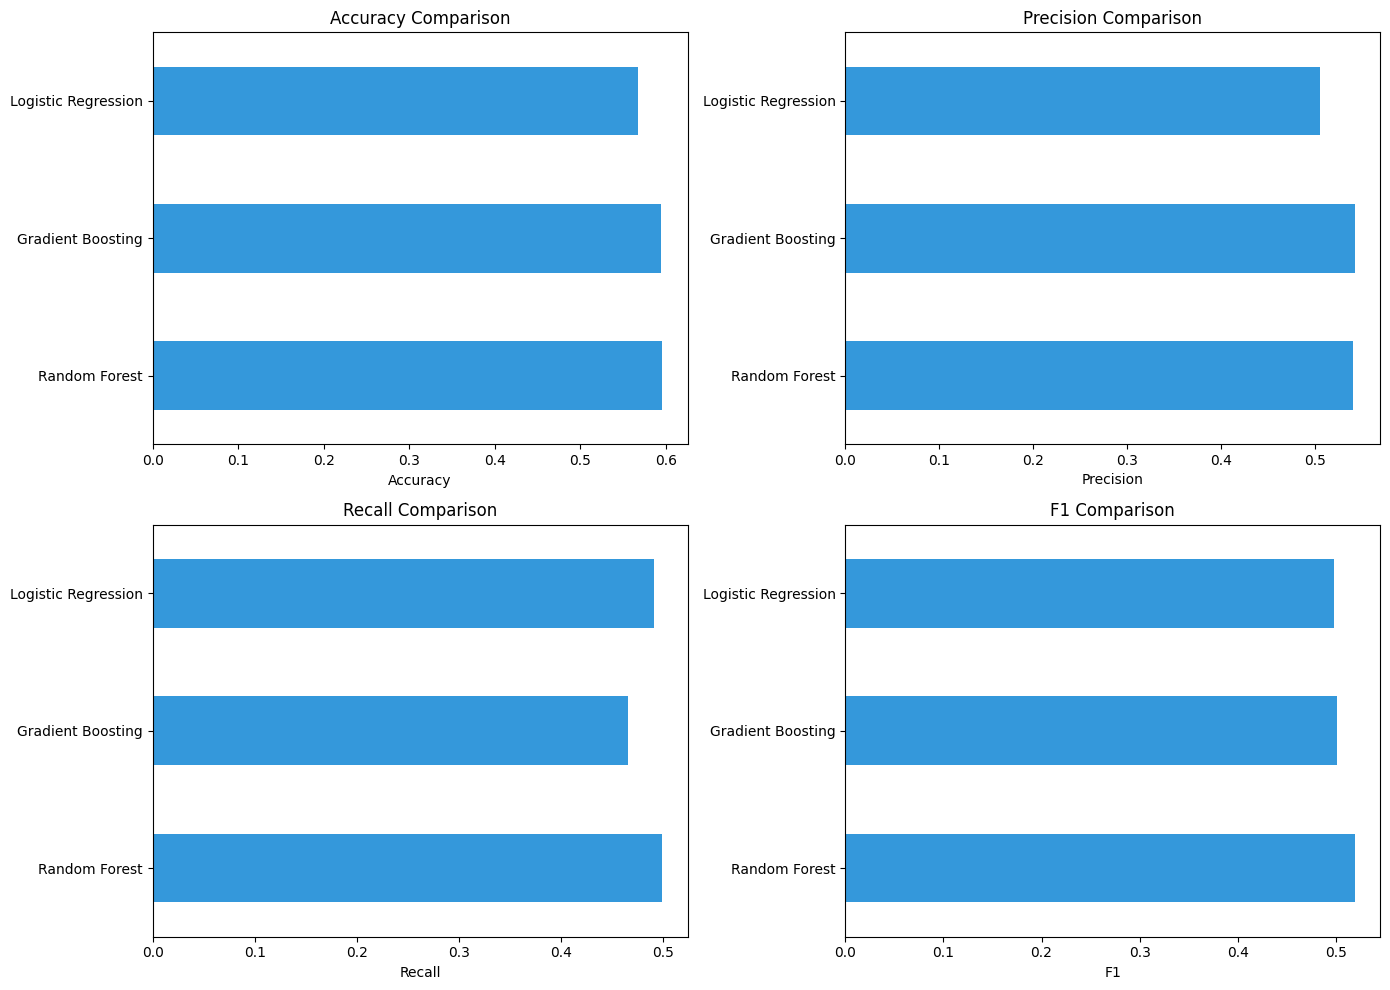

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    results_df.plot(x='Model', y=metric, kind='barh', ax=ax, legend=False, color='#3498db')
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Detailed Analysis of Best Model

In [60]:
best_model_name = results_df.iloc[0]['Model']

best_model_info = trained_models[best_model_name]
best_model = best_model_info['model']
best_predictions = best_model_info['predictions']

print(f"\nDetailed Analysis: {best_model_name}")
print(classification_report(y_test, best_predictions, target_names=['Cannot Cover', 'Can Cover']))


Detailed Analysis: Random Forest
              precision    recall  f1-score   support

Cannot Cover       0.63      0.67      0.65      1385
   Can Cover       0.54      0.50      0.52      1074

    accuracy                           0.60      2459
   macro avg       0.59      0.58      0.59      2459
weighted avg       0.59      0.60      0.59      2459



### Confusion Matrix

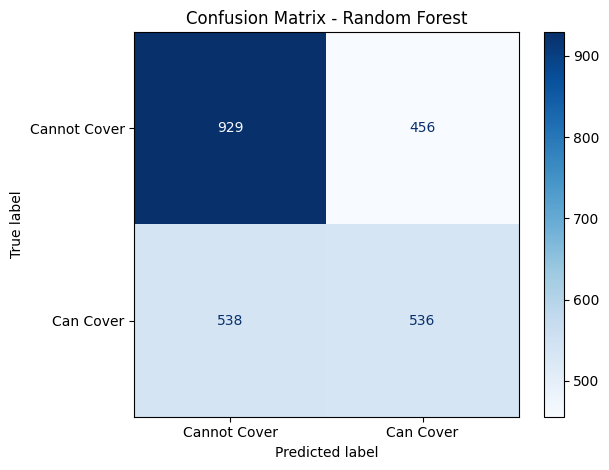

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model_name = results_df.iloc[0]['Model']
y_pred_best = trained_models[best_model_name]['predictions']

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cannot Cover', 'Can Cover'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix.png', dpi=300)
plt.show()

### ROC Curve

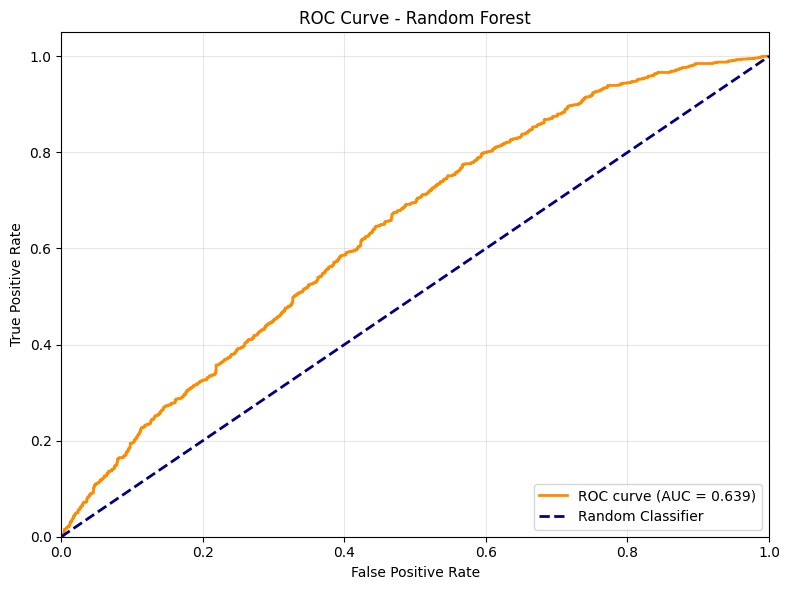

In [62]:
from sklearn.metrics import roc_curve, auc

y_proba_best = trained_models[best_model_name]['probabilities']
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/roc_curve.png', dpi=300)
plt.show()

### Learning Curve


Logistic Regression: High bias (underfitting) - both scores are low

Random Forest: High variance (overfitting) - training score much higher than validation

Gradient Boosting: High variance (overfitting) - training score much higher than validation


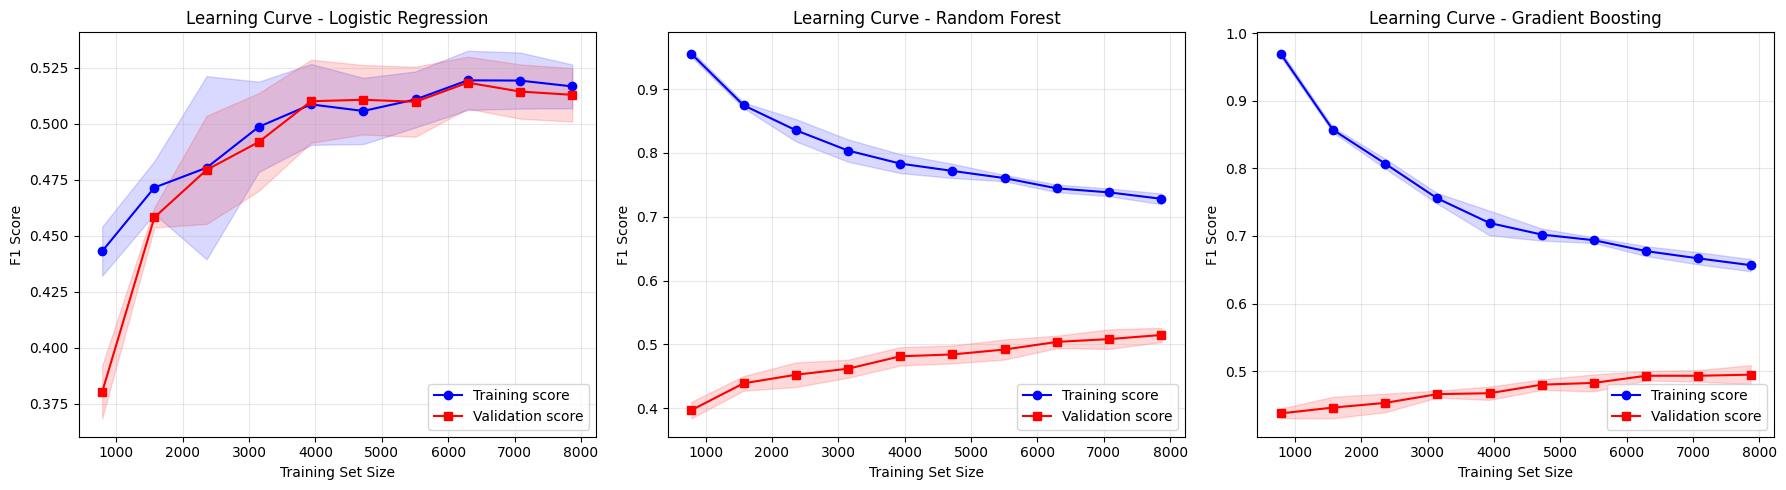


✓ Learning curves analysis complete


In [ ]:
from sklearn.model_selection import learning_curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model_dict) in enumerate(trained_models.items()):
    model = model_dict['model']
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1',
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    axes[idx].plot(train_sizes, val_mean, label='Validation score', color='red', marker='s')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')
    
    axes[idx].set_xlabel('Training Set Size')
    axes[idx].set_ylabel('F1 Score')
    axes[idx].set_title(f'Learning Curve - {name}')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)
    
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        print(f"\n{name}: High variance (overfitting) - training score much higher than validation")
    elif val_mean[-1] < 0.7:
        print(f"\n{name}: High bias (underfitting) - both scores are low")
    else:
        print(f"\n{name}: Good fit - training and validation scores converge")

plt.tight_layout()
plt.savefig('../results/figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLearning curves analysis complete")

### Feature Importance

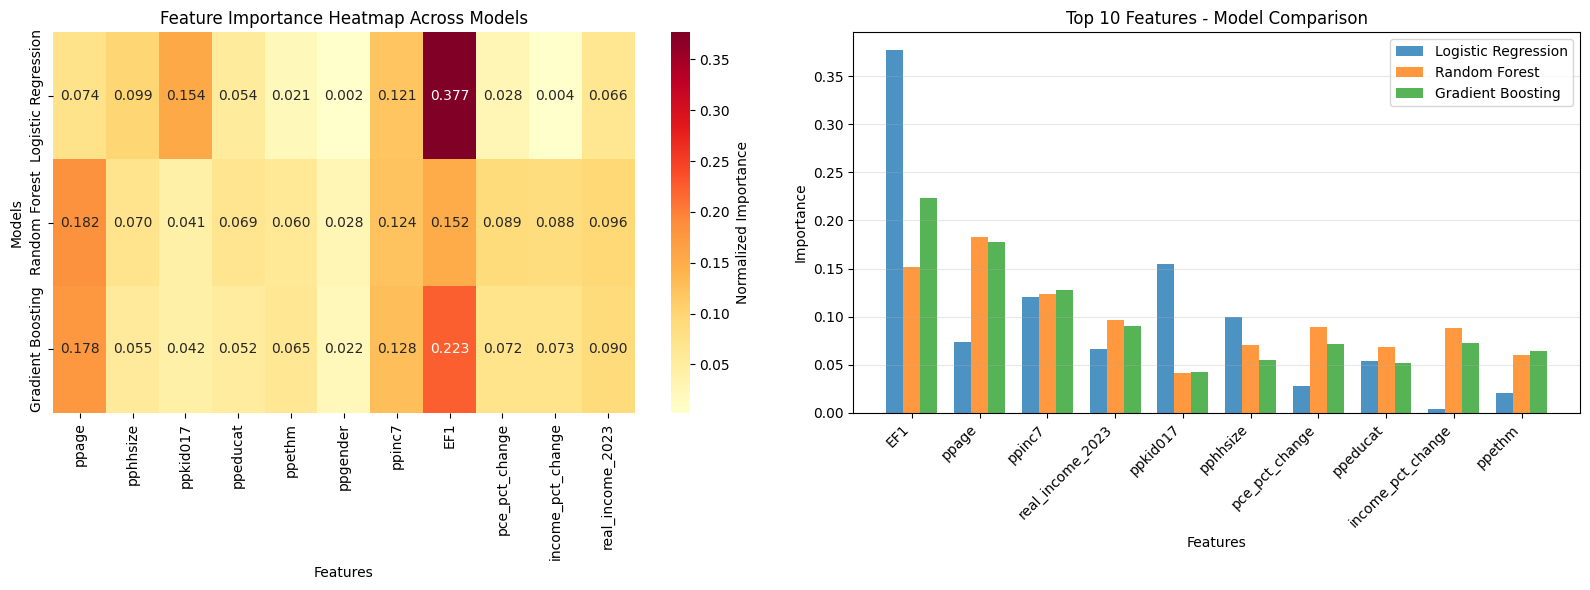


Top 5 Features (averaged across all models):
EF1                 0.250529
ppage               0.144520
ppinc7              0.124169
real_income_2023    0.084175
ppkid017            0.079176
dtype: float64

✓ Feature importance comparison complete


In [ ]:
importance_data = {}

for name, model_dict in trained_models.items():
    model = model_dict['model']
    
    if name == 'Logistic Regression':
        importance = np.abs(model.coef_[0])
    else:
        importance = model.feature_importances_
    
    importance = importance / importance.sum()
    importance_data[name] = importance

importance_df = pd.DataFrame(importance_data, index=feature_names)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

import seaborn as sns
sns.heatmap(importance_df.T, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Normalized Importance'})
axes[0].set_title('Feature Importance Heatmap Across Models')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Models')

top_features = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
x = np.arange(len(top_features))
width = 0.25

for i, (name, values) in enumerate(importance_df.T.iterrows()):
    offset = (i - 1) * width
    axes[1].bar(x + offset, values[top_features.index], width, label=name, alpha=0.8)

axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('Top 10 Features - Model Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_features.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Features (averaged across all models):")
print(importance_df.mean(axis=1).sort_values(ascending=False).head(5))

print("\n Feature importance comparison complete")

### Error Analysis


ERROR ANALYSIS

Total test samples: 2459
Correctly classified: 1465 (59.6%)
Misclassified: 994 (40.4%)

False Positives (predicted CAN cover, actually CANNOT): 456
False Negatives (predicted CANNOT cover, actually CAN): 538

--------------------------------------------------------------------------------
CHARACTERISTICS OF FALSE POSITIVES (Model overestimates ability to cover)
--------------------------------------------------------------------------------
EF1                  0.691230
ppage                0.344817
ppeducat             0.260210
ppinc7               0.257324
pce_pct_change       0.041279
income_pct_change    0.039877
real_income_2023    -0.096416
ppgender            -0.097743
ppethm              -0.105462
ppkid017            -0.227879
pphhsize            -0.272808
dtype: float64

--------------------------------------------------------------------------------
CHARACTERISTICS OF FALSE NEGATIVES (Model underestimates ability to cover)
------------------------------------

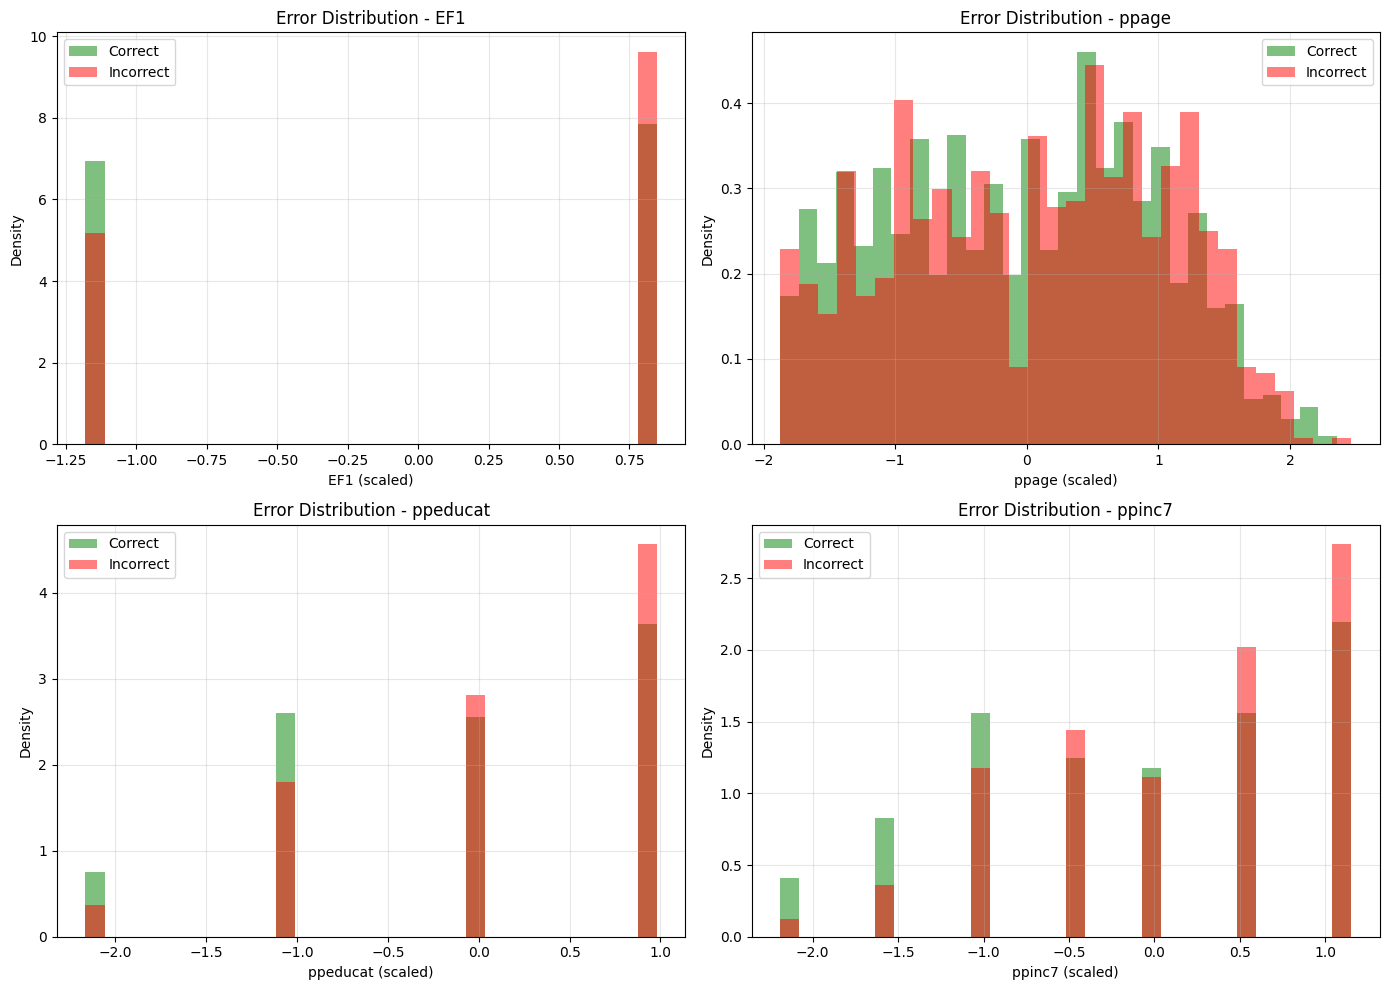


✓ Error analysis complete


In [ ]:
with open('../data/processed/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

y_pred = best_model.predict(X_test_scaled)

correct_mask = y_test == y_pred
incorrect_mask = ~correct_mask

print(f"\nTotal test samples: {len(y_test)}")
print(f"Correctly classified: {correct_mask.sum()} ({correct_mask.mean()*100:.1f}%)")
print(f"Misclassified: {incorrect_mask.sum()} ({incorrect_mask.mean()*100:.1f}%)")

false_positives = (y_test == 0) & (y_pred == 1)
false_negatives = (y_test == 1) & (y_pred == 0)

print(f"\nFalse Positives (predicted CAN cover, actually CANNOT): {false_positives.sum()}")
print(f"False Negatives (predicted CANNOT cover, actually CAN): {false_negatives.sum()}")

X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print("\n" + "-"*80)
print("CHARACTERISTICS OF FALSE POSITIVES (Model overestimates ability to cover)")
print("-"*80)
fp_characteristics = X_test_df[false_positives].mean()
print(fp_characteristics.sort_values(ascending=False))

print("\n" + "-"*80)
print("CHARACTERISTICS OF FALSE NEGATIVES (Model underestimates ability to cover)")
print("-"*80)
fn_characteristics = X_test_df[false_negatives].mean()
print(fn_characteristics.sort_values(ascending=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
top_4_features = list(fp_characteristics.sort_values(ascending=False).head(4).index)

for idx, feature in enumerate(top_4_features):
    ax = axes[idx // 2, idx % 2]
    
    feature_idx = feature_names.index(feature)
    
    ax.hist(X_test_scaled[correct_mask, feature_idx], bins=30, alpha=0.5, 
            label='Correct', color='green', density=True)
    ax.hist(X_test_scaled[incorrect_mask, feature_idx], bins=30, alpha=0.5, 
            label='Incorrect', color='red', density=True)
    
    ax.set_xlabel(f'{feature} (scaled)')
    ax.set_ylabel('Density')
    ax.set_title(f'Error Distribution - {feature}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nError analysis complete")


CROSS-VALIDATION ANALYSIS

Logistic Regression:
  Accuracy:  0.583 ± 0.011
  Precision: 0.523 ± 0.013
  Recall:    0.503 ± 0.015
  F1:        0.513 ± 0.012

Random Forest:
  Accuracy:  0.598 ± 0.008
  Precision: 0.545 ± 0.011
  Recall:    0.486 ± 0.020
  F1:        0.513 ± 0.011

Gradient Boosting:
  Accuracy:  0.588 ± 0.008
  Precision: 0.534 ± 0.012
  Recall:    0.456 ± 0.015
  F1:        0.492 ± 0.007


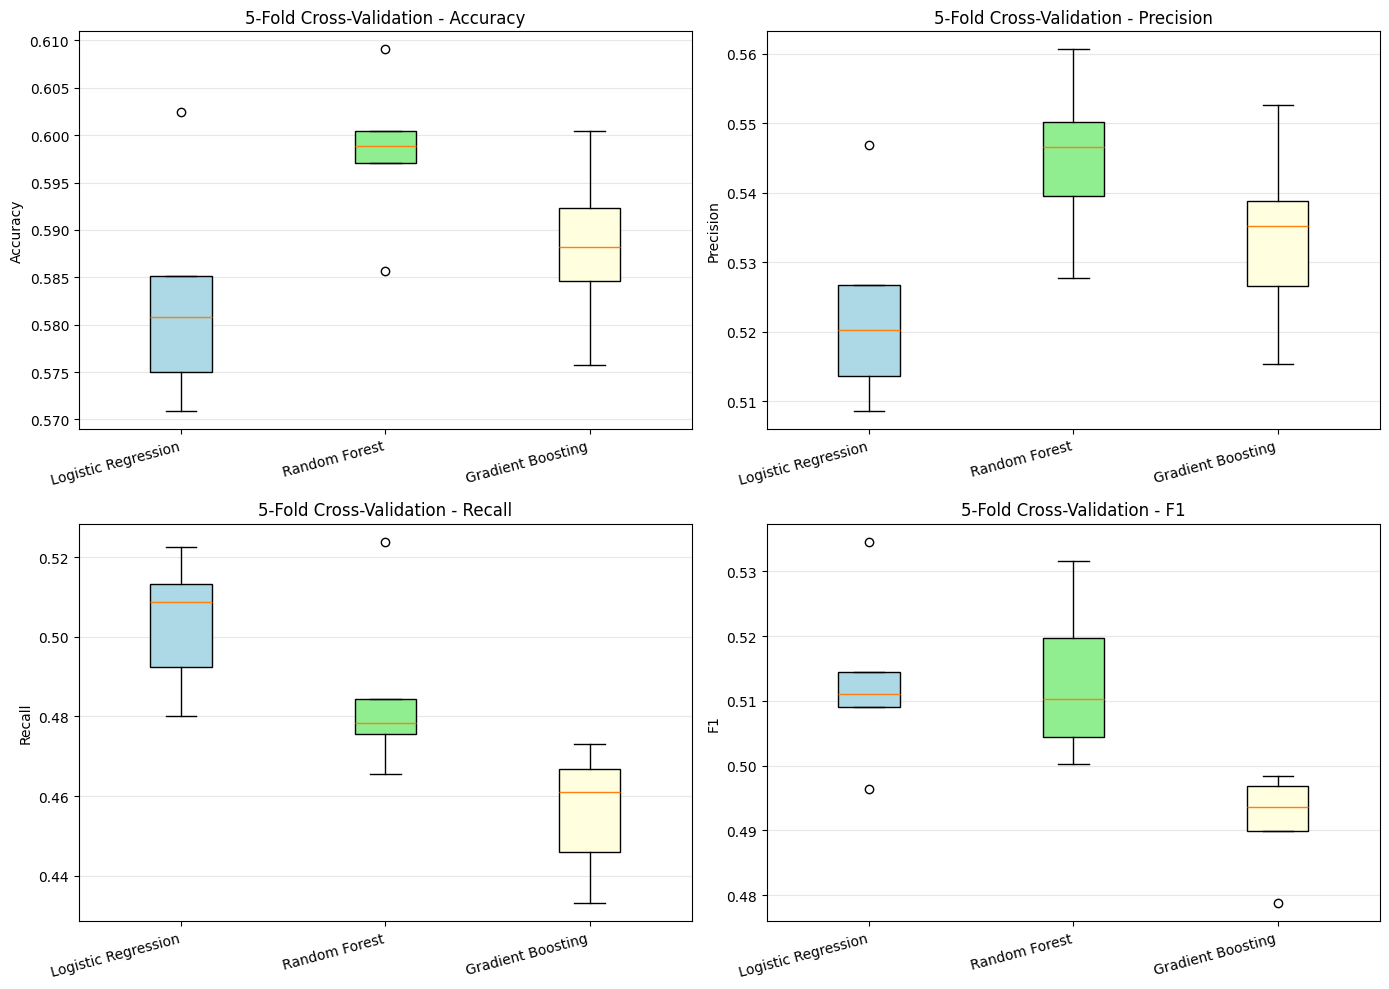


--------------------------------------------------------------------------------
MODEL STABILITY (Lower std = more stable)
--------------------------------------------------------------------------------
                     Accuracy  Precision    Recall        F1
Logistic Regression  0.010931   0.013301  0.015230  0.012338
Random Forest        0.007504   0.010947  0.020080  0.011249
Gradient Boosting    0.008175   0.012430  0.014605  0.007017

Most stable model (F1): Gradient Boosting

✓ Cross-validation analysis complete


In [ ]:
cv_results = {}

for name, model_dict in trained_models.items():
    model = model_dict['model']
    
    cv_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='precision')
    cv_recall = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='recall')
    cv_f1 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    
    cv_results[name] = {
        'Accuracy': cv_accuracy,
        'Precision': cv_precision,
        'Recall': cv_recall,
        'F1': cv_f1
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {cv_accuracy.mean():.3f} ± {cv_accuracy.std():.3f}")
    print(f"  Precision: {cv_precision.mean():.3f} ± {cv_precision.std():.3f}")
    print(f"  Recall:    {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")
    print(f"  F1:        {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    data_to_plot = [cv_results[name][metric] for name in trained_models.keys()]
    
    bp = ax.boxplot(data_to_plot, labels=trained_models.keys(), patch_artist=True)
    
    colors = ['lightblue', 'lightgreen', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(metric)
    ax.set_title(f'5-Fold Cross-Validation - {metric}')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(trained_models.keys(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig('../results/figures/cv_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "-"*80)
print("MODEL STABILITY (Lower std = more stable)")
print("-"*80)

stability_df = pd.DataFrame({
    name: {metric: cv_results[name][metric].std() for metric in metrics}
    for name in trained_models.keys()
}).T

print(stability_df)

most_stable = stability_df['F1'].idxmin()
print(f"\nMost stable model (F1): {most_stable}")

print("\nCross-validation analysis complete")

## Save Models and Results

In [ ]:
with open('../data/processed/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('../data/processed/trained_models.pkl', 'wb') as f:
    pickle.dump(trained_models, f)

results_df.to_csv('../data/processed/model_results.csv', index=False)

with open('../data/processed/best_model_name.pkl', 'wb') as f:
    pickle.dump(best_model_name, f)

print(f"\nBest model ({best_model_name}) saved successfully")
print(f"All results saved to ../data/processed/")


Best model (Random Forest) saved successfully
All results saved to ../data/processed/


## Summary

In [ ]:
print("=" * 80)
print("MODEL TRAINING SUMMARY")
print("=" * 80)
print(f"\nBest Model: {best_model_name}")
print(f"\nPerformance:")
best_row = results_df.iloc[0]
print(f"  Accuracy:  {best_row['Accuracy']:.4f}")
print(f"  Precision: {best_row['Precision']:.4f}")
print(f"  Recall:    {best_row['Recall']:.4f}")
print(f"  F1-Score:  {best_row['F1']:.4f}")
print(f"  ROC-AUC:   {best_row['ROC-AUC']:.4f}")
print(f"\nCross-validation F1: {best_row['CV Mean']:.4f} (±{best_row['CV Std']:.4f})")
print(f"\nTraining time: {best_row['Time']:.2f} seconds")
print("\n" + "=" * 80)
print("Ready to proceed to analysis notebook for SHAP and hyperparameter tuning")
print("=" * 80)

MODEL TRAINING SUMMARY

Best Model: Random Forest

Performance:
  Accuracy:  0.5958
  Precision: 0.5403
  Recall:    0.4991
  F1-Score:  0.5189
  ROC-AUC:   0.6385

Cross-validation F1: 0.5132 (±0.0112)

Training time: 0.16 seconds

Ready to proceed to analysis notebook for SHAP and hyperparameter tuning
